In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import time

# Ф-ии

In [2]:
def corr(data, target):
    correlation = data.corr()
    corr_with_target = correlation[target].sort_values(ascending = False)
    print(corr_with_target)
    fig, axes = plt.subplots(figsize = (14,12))
    plt.title("Correlation of Numeric Features with target", y=1, size=16)
    sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

# Чтение данных

In [3]:
os.listdir("data")

['medical_examination.csv', 'oof.csv']

In [4]:
data = pd.read_csv('data/medical_examination.csv')

In [5]:
data.head()

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
data["age"] = data["age"].apply(lambda x: round(x/365, 1))

In [7]:
def quantile_99(x):
    return x.quantile(0.99)

In [8]:
data_stat = data.agg(["min", "max", quantile_99, "count", "mean", "nunique"]).T
data_stat

,min,max,quantile_99,count,mean,nunique
id,0.0,99999.0,98974.05,70000.0,49972.419900,70000.0
age,29.6,65.0,64.40,70000.0,53.339486,262.0
sex,1.0,3.0,2.00,70000.0,1.349843,3.0
height,55.0,250.0,184.00,70000.0,164.359229,109.0
weight,10.0,200.0,117.00,70000.0,74.205690,287.0
ap_hi,-150.0,16020.0,180.00,70000.0,128.817286,153.0
ap_lo,-70.0,11000.0,1000.00,70000.0,96.630414,157.0
cholesterol,1.0,3.0,3.00,70000.0,1.366871,3.0
gluc,1.0,3.0,3.00,70000.0,1.226457,3.0
smoke,0.0,1.0,1.00,70000.0,0.088129,2.0


In [9]:
for i in data:
    print(i)
    print("значений больше 99 перцентиля: {}".format(data[i].loc[data[i] > data_stat["quantile_99"][i]].shape[0]))


id
значений больше 99 перцентиля: 700
age
значений больше 99 перцентиля: 440
sex
значений больше 99 перцентиля: 11
height
значений больше 99 перцентиля: 605
weight
значений больше 99 перцентиля: 691
ap_hi
значений больше 99 перцентиля: 369
ap_lo
значений больше 99 перцентиля: 255
cholesterol
значений больше 99 перцентиля: 0
gluc
значений больше 99 перцентиля: 0
smoke
значений больше 99 перцентиля: 0
alco
значений больше 99 перцентиля: 0
active
значений больше 99 перцентиля: 0
cardio
значений больше 99 перцентиля: 0


In [10]:
data["sex"].loc[data["sex"] == 3] = data["sex"].median()

c:\program files\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
data["sex"].unique()

array([2, 1], dtype=int64)

# распределение переменной

c:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\program files\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Index')

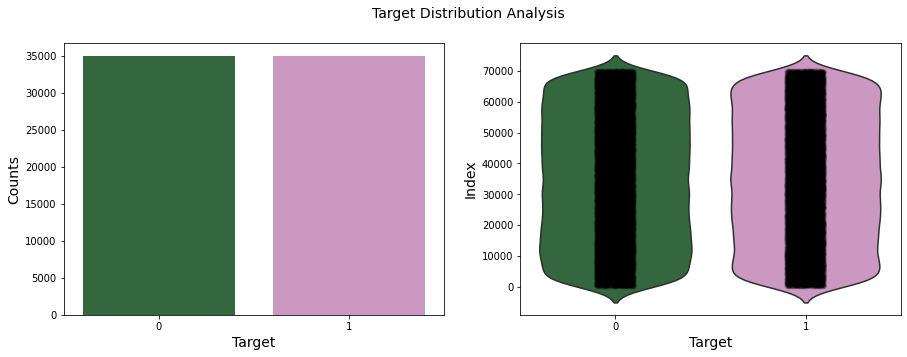

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)

sns.countplot(data["cardio"], ax=axes[0], palette="cubehelix")
sns.violinplot(data["cardio"], data.index, ax=axes[1], palette="cubehelix")
sns.stripplot(data["cardio"], data.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

# Удаление выбросов

In [13]:
data["ap_hi"].loc[data["ap_hi"] > data_stat["quantile_99"]["ap_hi"]].index

Int64Index([  101,   559,   649,   965,  1328,  1876,  2014,  2142,  2278,
             2628,
            ...
            68469, 68579, 68663, 68699, 69115, 69329, 69370, 69405, 69440,
            69894],
           dtype='int64', length=369)

In [14]:
data = data.drop(data.loc[data["ap_hi"] > data_stat["quantile_99"]["ap_hi"]].index)

In [15]:
data = data.drop(data.loc[data["ap_lo"] > data_stat["quantile_99"]["ap_lo"]].index)

In [16]:
data.isna().sum()

id             0
age            0
sex            0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [17]:
for i in data:
    print(i)
    print("значений больше 99 перцентиля: {}".format(data[i].loc[data[i] > data_stat["quantile_99"][i]].shape[0]))


id
значений больше 99 перцентиля: 694
age
значений больше 99 перцентиля: 437
sex
значений больше 99 перцентиля: 0
height
значений больше 99 перцентиля: 600
weight
значений больше 99 перцентиля: 666
ap_hi
значений больше 99 перцентиля: 0
ap_lo
значений больше 99 перцентиля: 0
cholesterol
значений больше 99 перцентиля: 0
gluc
значений больше 99 перцентиля: 0
smoke
значений больше 99 перцентиля: 0
alco
значений больше 99 перцентиля: 0
active
значений больше 99 перцентиля: 0
cardio
значений больше 99 перцентиля: 0


# Корреляция

In [18]:
data.columns

Index(['id', 'age', 'sex', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

cardio         1.000000
ap_hi          0.404231
age            0.238858
cholesterol    0.220785
weight         0.179323
ap_lo          0.105244
gluc           0.088469
sex            0.007158
id             0.003970
alco          -0.007998
height        -0.010938
smoke         -0.016342
active        -0.035981
Name: cardio, dtype: float64


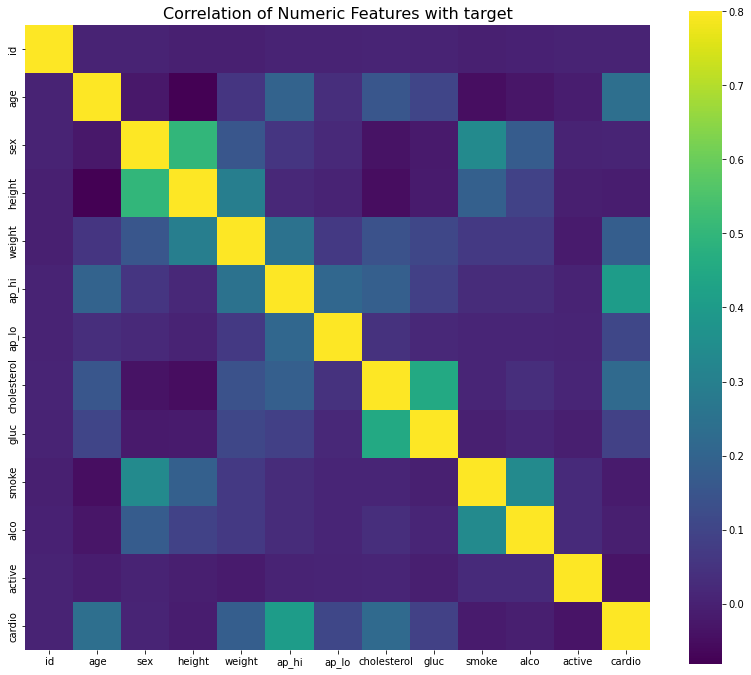

In [19]:
corr(data, "cardio")

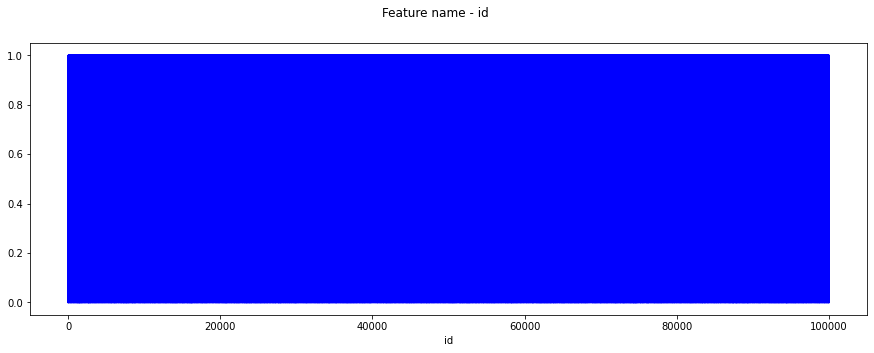

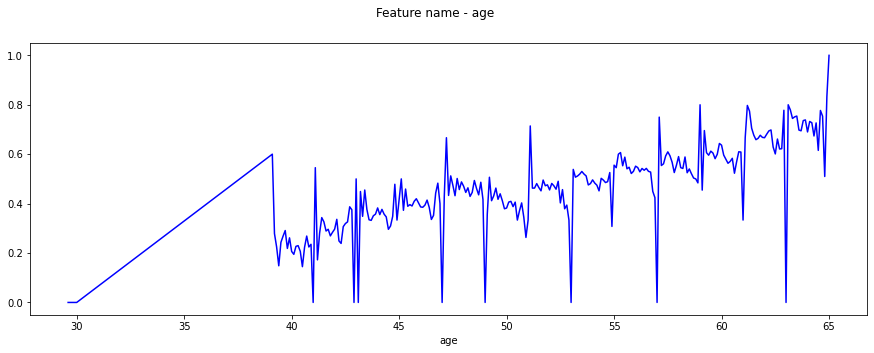

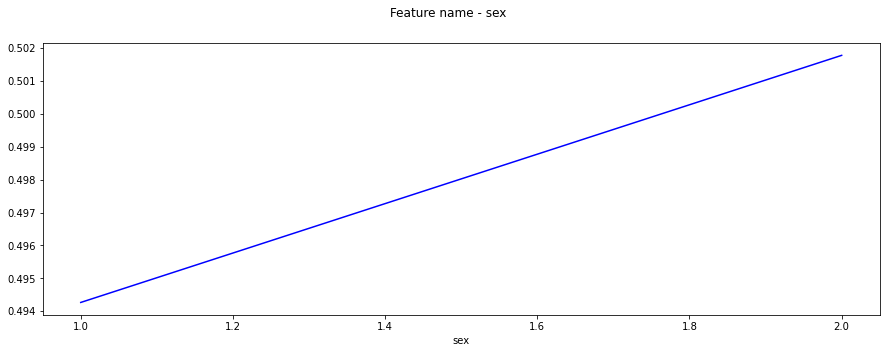

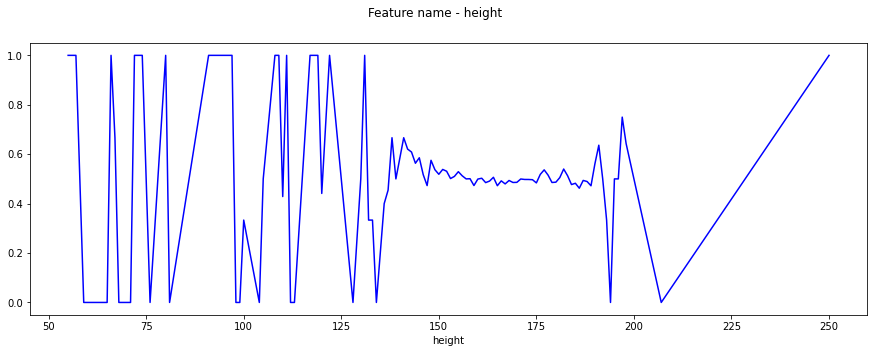

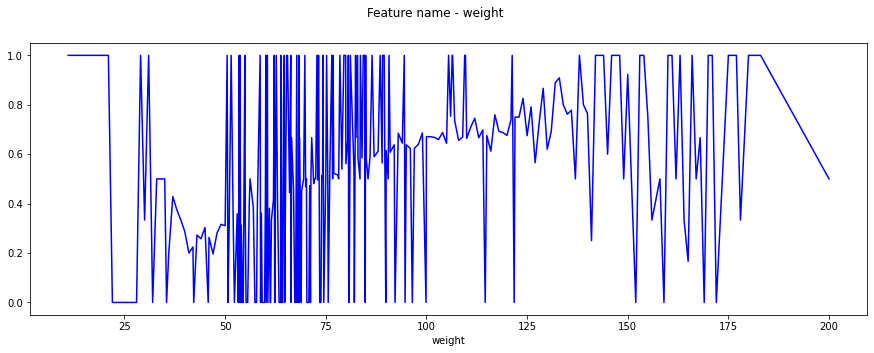

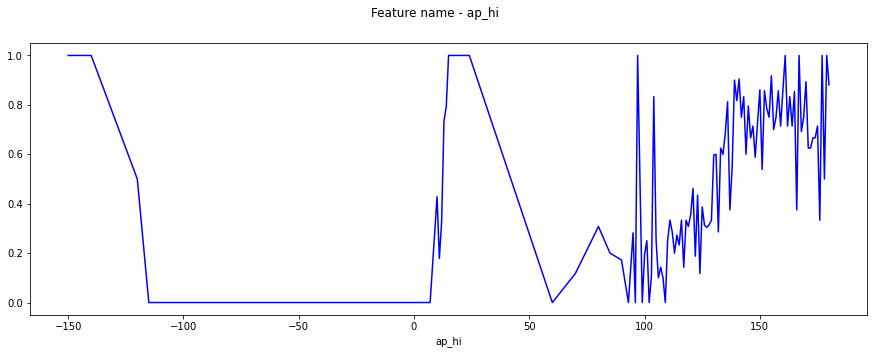

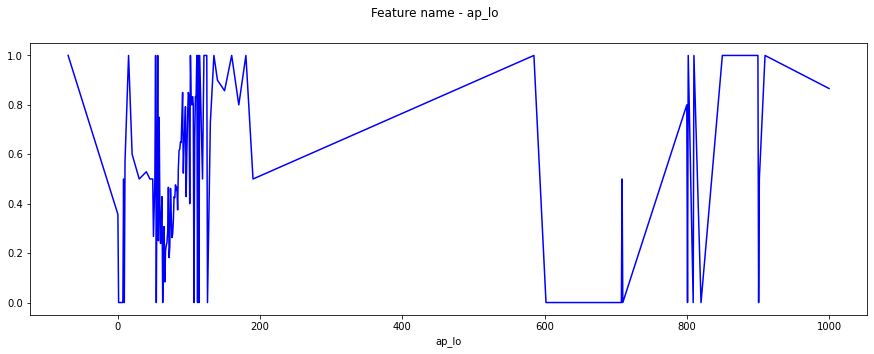

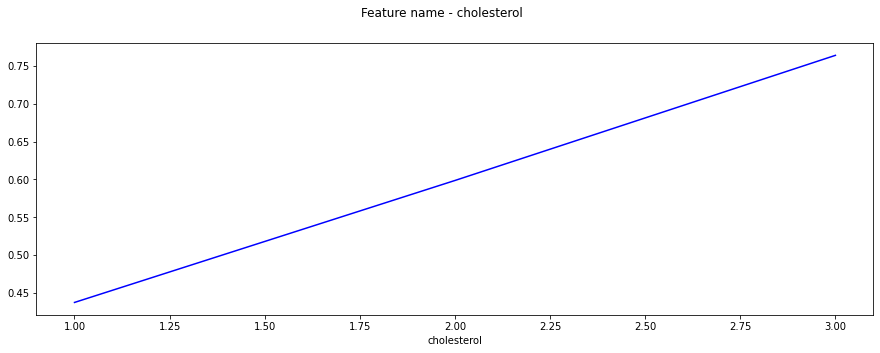

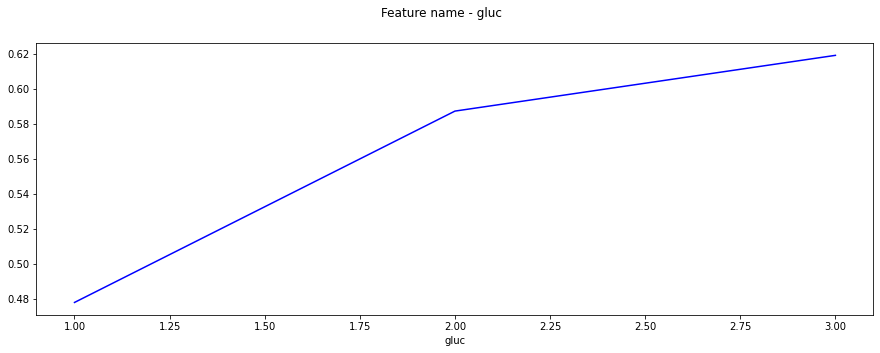

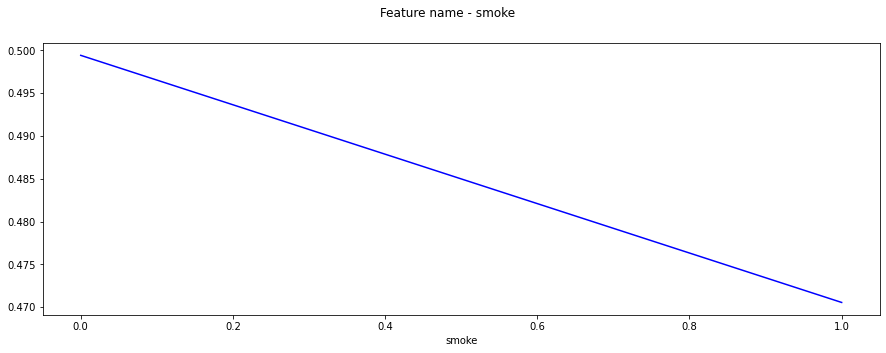

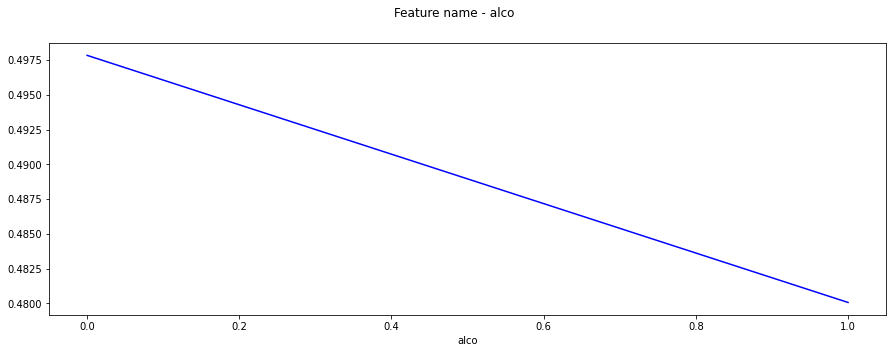

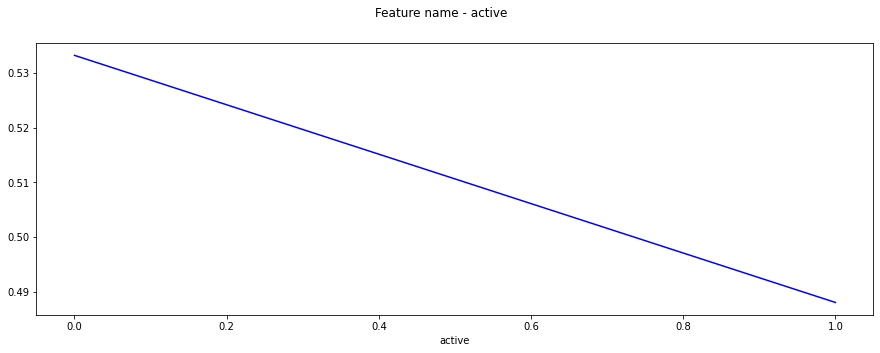

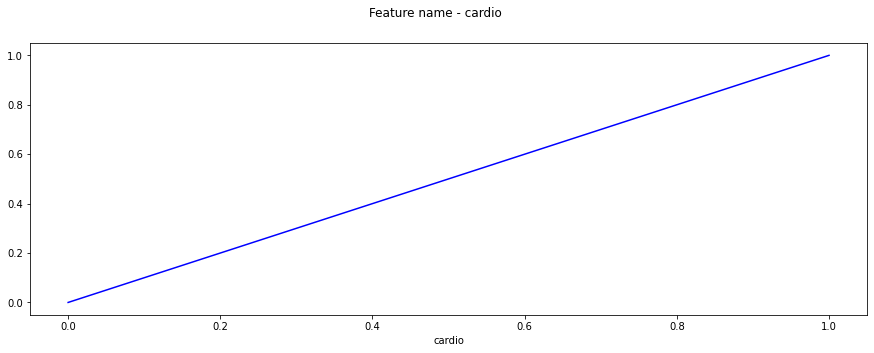

In [20]:
for col in data:
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature name - {col}")
    data.groupby([col])["cardio"].mean().plot(color="blue")

In [21]:
stats.boxcox(data["age"])[0]

array([1511.76306636, 1835.52072731, 1592.84759269, ..., 1624.611981  ,
       2274.17020629, 1897.21602896])

In [22]:
data.columns

Index(['id', 'age', 'sex', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [23]:
df_linear = data.copy()
df_linear = df_linear[["age", "height", "weight"]]
for i in df_linear:
    print(i)
    df_linear[i] = stats.boxcox(df_linear[i])[0]
df_linear[["cardio", 'cholesterol', 'gluc', 'smoke', 'alco', 'active']] = data[["cardio", 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]

age
height
weight


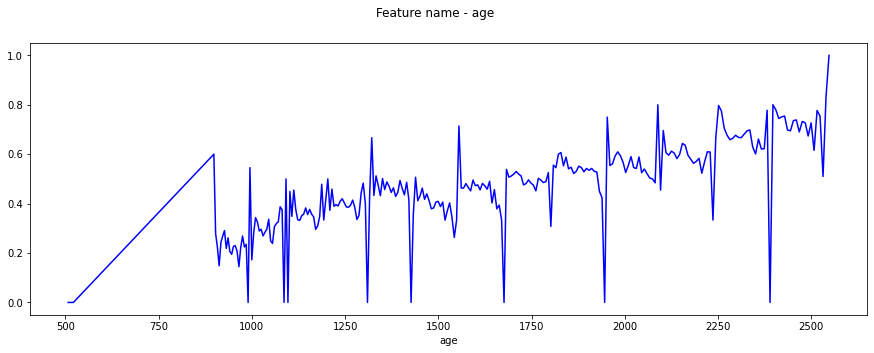

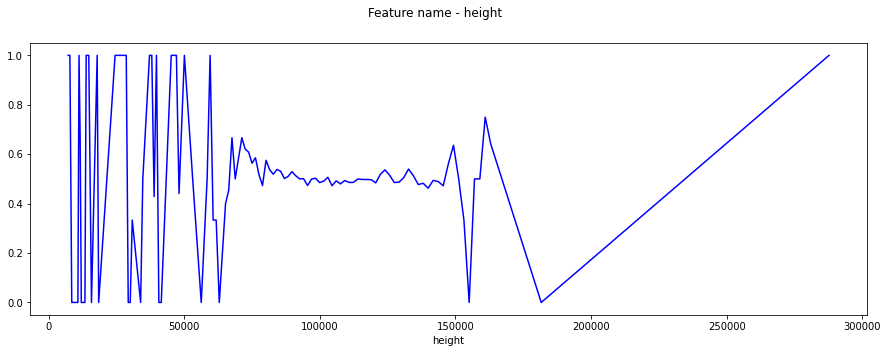

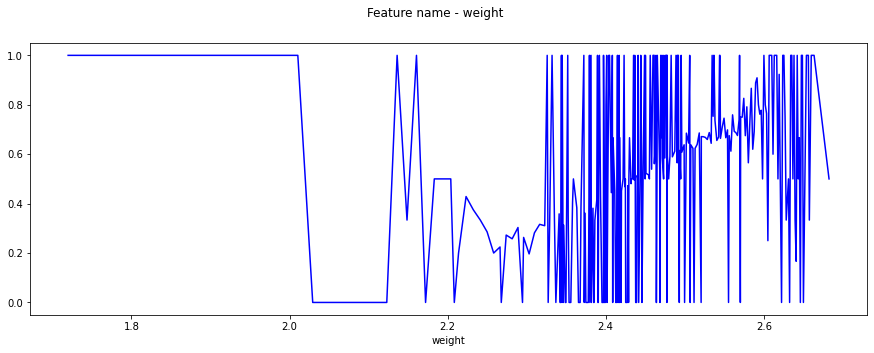

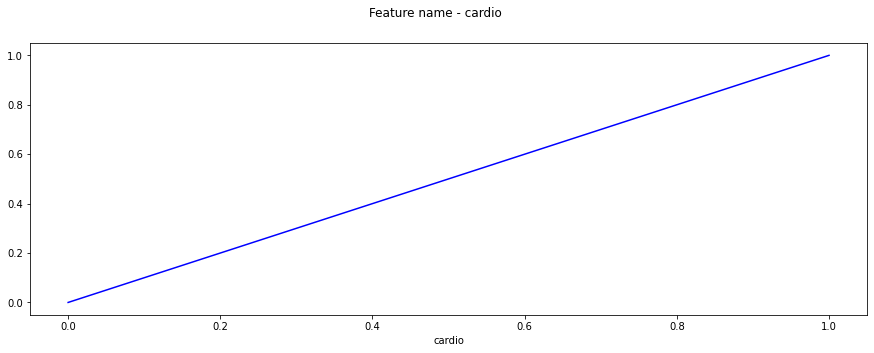

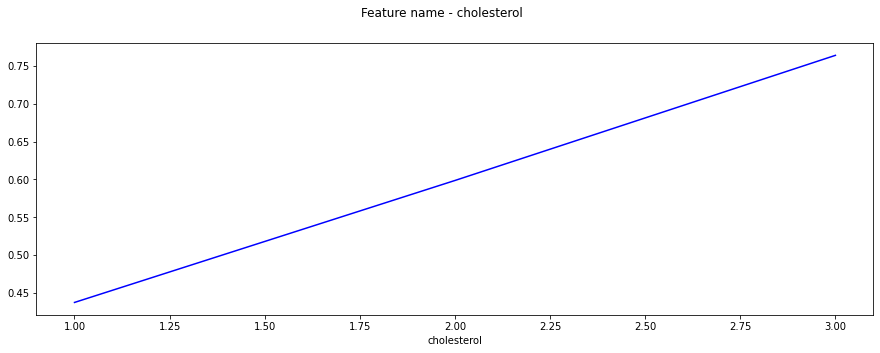

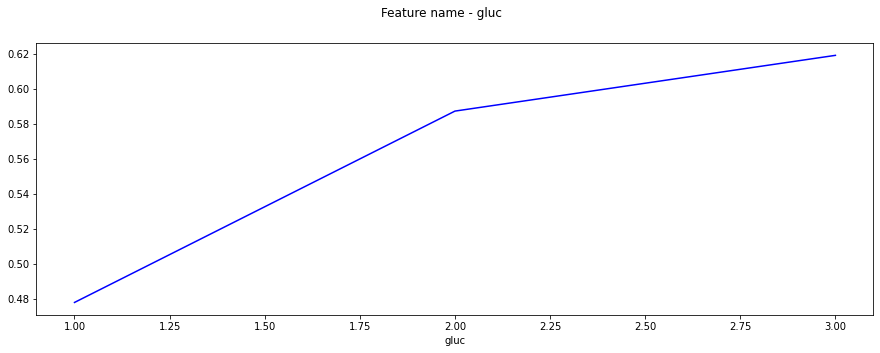

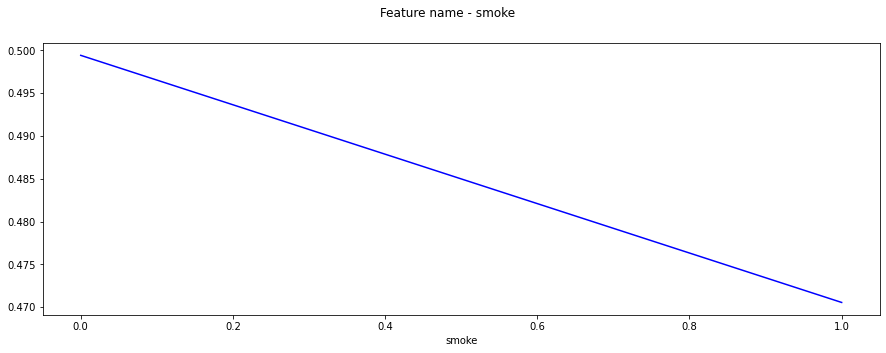

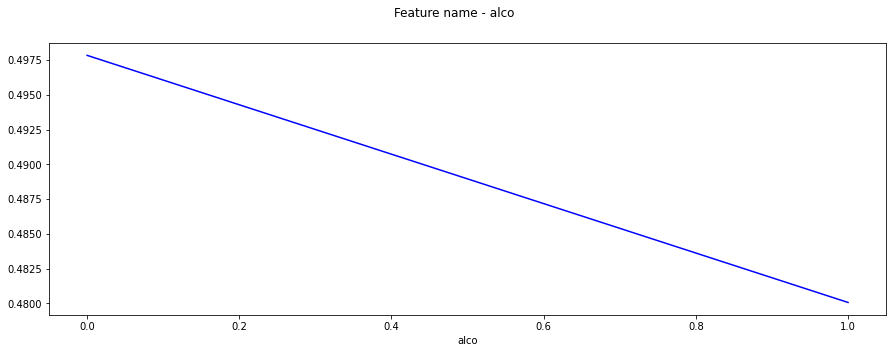

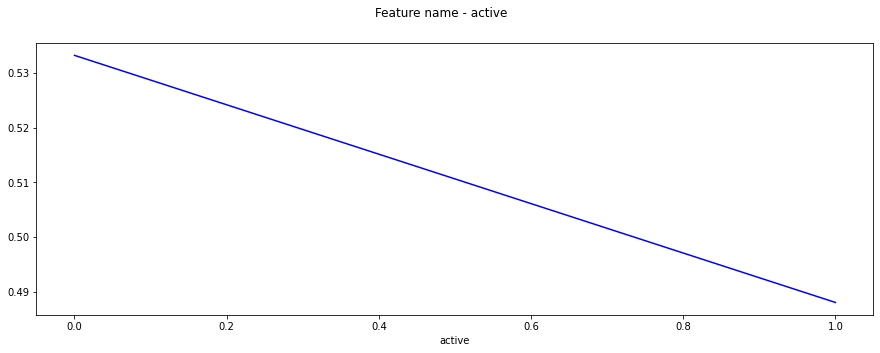

In [24]:
for col in df_linear:
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature name - {col}")
    df_linear.groupby([col])["cardio"].mean().plot(color="blue")

# LogisticRegression

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(df_linear.drop("cardio", axis=1), df_linear["cardio"], test_size = 0.2)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((55518, 8), (13880, 8), (55518,), (13880,))

In [26]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

In [27]:
pred = clf.predict(x_valid)

In [28]:
pred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [29]:
roc_auc_score(y_valid, pred)

0.5893619549258652

In [30]:
confusion_matrix(y_valid, pred)

array([[3961, 3048],
       [2655, 4216]], dtype=int64)

In [31]:
accuracy_score(y_valid, pred)

0.5891210374639769

In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(data.drop(["cardio", "id"], axis=1), data["cardio"], test_size = 0.2)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((55518, 11), (13880, 11), (55518,), (13880,))

In [33]:
data.isna().sum()

id             0
age            0
sex            0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [34]:
clf = LogisticRegression(random_state=37, max_iter=1000).fit(x_train, y_train)
pred = clf.predict(x_valid)
print(roc_auc_score(y_valid, pred))
print(confusion_matrix(y_valid, pred))
print(accuracy_score(y_valid, pred))

0.7239503347389215
[[5412 1499]
 [2336 4633]]
0.7237031700288185


In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(data)
X_train_minmax

array([[0.00000000e+00, 5.87570621e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00001000e-05, 7.28813559e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00002000e-05, 6.24293785e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [9.99970000e-01, 6.38418079e-01, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [9.99990000e-01, 9.01129944e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 7.54237288e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [36]:
data_scaler = pd.DataFrame(X_train_minmax, columns=[data.columns])

In [37]:
data_scaler.head()

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.00000,0.587571,1.0,0.579487,0.269841,0.787879,0.140187,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00001,0.728814,0.0,0.517949,0.391534,0.878788,0.149533,1.0,0.0,0.0,0.0,1.0,1.0
2,0.00002,0.624294,0.0,0.564103,0.280423,0.848485,0.130841,1.0,0.0,0.0,0.0,0.0,1.0
3,0.00003,0.528249,1.0,0.584615,0.375661,0.909091,0.158879,0.0,0.0,0.0,0.0,1.0,1.0
4,0.00004,0.516949,0.0,0.517949,0.238095,0.757576,0.121495,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
data_scaler.agg(["max", quantile_99, "nunique"]).T

,max,quantile_99,nunique
id,1.0,0.989751,69398.0
age,1.0,0.983051,262.0
sex,1.0,1.000000,2.0
height,1.0,0.661538,108.0
weight,1.0,0.560847,283.0
ap_hi,1.0,0.972818,107.0
ap_lo,1.0,0.205607,112.0
cholesterol,1.0,1.000000,3.0
gluc,1.0,1.000000,3.0
smoke,1.0,1.000000,2.0


In [39]:
data_scaler.columns = data_scaler.columns.map(''.join)

In [40]:
x_train, x_valid, y_train, y_valid = train_test_split(data_scaler.drop(["cardio", "id"], axis=1), data_scaler["cardio"], test_size = 0.2)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(55518, 11) (13880, 11) (55518,) (13880,)


In [41]:
x_train.columns

Index(['age', 'sex', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active'],
      dtype='object')

In [42]:
clf_2 = LogisticRegression(random_state=37, max_iter=1000).fit(x_train, y_train)
pred = clf_2.predict(x_valid)
print(roc_auc_score(y_valid, pred))
print(confusion_matrix(y_valid, pred))
print(accuracy_score(y_valid, pred))

0.7233648653418517
[[5379 1531]
 [2312 4658]]
0.7231268011527378


In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
parameters = {'max_iter':[100,200,300,400,500,1000,10000], "C": [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
             }

# L1 penalty

In [45]:
# , 'penalty':['l1', 'l2', 'elasticnet']
lr = LogisticRegression(solver='liblinear', penalty = "l1")

In [46]:
clf_l1 = GridSearchCV(lr, parameters)

In [47]:
%%time
clf_l1.fit(x_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Wall time: 19min 11s


GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1.0, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300, 400, 500, 1000, 10000]})

In [48]:
sorted(clf_l1.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_max_iter',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [49]:
clf_l1.best_params_

{'C': 100, 'max_iter': 100}

In [50]:
pred = clf_l1.predict(x_valid)

In [51]:
print(roc_auc_score(y_valid, pred))
print(confusion_matrix(y_valid, pred))
print(accuracy_score(y_valid, pred))

0.7244471344006876
[[5389 1521]
 [2307 4663]]
0.7242074927953891


# l2 penalty

In [52]:
%%time
# , 'penalty':['l1', 'l2', 'elasticnet']
lr = LogisticRegression( penalty = "l2")
clf_l2 = GridSearchCV(lr, parameters)

clf_l2.fit(x_train, y_train)
print("лучшие параметры: ", clf_l2.best_params_)
pred = clf_l2.predict(x_valid)
print(roc_auc_score(y_valid, pred))
print(confusion_matrix(y_valid, pred))
print(accuracy_score(y_valid, pred))

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


лучшие параметры:  {'C': 1000, 'max_iter': 100}
0.7244471344006876
[[5389 1521]
 [2307 4663]]
0.7242074927953891
Wall time: 1min 36s


In [53]:
pred = clf_l2.predict_proba(x_valid)

In [54]:
pred

array([[0.1930164 , 0.8069836 ],
       [0.92719505, 0.07280495],
       [0.20270201, 0.79729799],
       ...,
       [0.77157102, 0.22842898],
       [0.28576201, 0.71423799],
       [0.92569123, 0.07430877]])

In [55]:
pred = np.where(pred[:,1] > 0.3, 1, 0)

In [56]:
print(confusion_matrix(y_valid, pred))

[[2610 4300]
 [ 652 6318]]


# catboost, xgboost, randomforest

In [57]:
import catboost as cb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [58]:
# CatBoost
def catboost_base(x, x_val, y, y_val, cb_params = None):
    if cb_params == None:
        cb_params = {
        "n_estimators": 2000,
        "learning_rate": 0.001,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "max_bin": 20,
        "verbose": False,
        "max_depth": 6,
        "l2_leaf_reg": 10,
        "early_stopping_rounds": 50,
        "thread_count": 6,
        "random_seed": 42
        }

    model = cb.CatBoostClassifier(**cb_params)
    model.fit(x, y,
        )
    y_pred = model.predict(x_val)
    print("roc_auc_score: ",roc_auc_score(y_val, y_pred))
    print("confusion_matrix: ",confusion_matrix(y_val, y_pred))
    print("accuracy_score: ",accuracy_score(y_val, y_pred))

In [59]:
# XGBoost
def xgb_base(x, x_val, y, y_val):

    params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27
    }

    dtrain = xgb.DMatrix(
    x, y
    )
    dvalid = xgb.DMatrix(
    x_val, y_val
    )

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=25,
        num_boost_round=1000,
#         verbose_eval=10,
        maximize=True,
    )


In [60]:
def forest_base(x, x_val, y, y_val):
    model = RandomForestClassifier(
    n_estimators=250, max_depth=8, n_jobs=6, random_state=27
    )
    model.fit(x, y)
    y_pred = model.predict(x_val)
    print("roc_auc_score: ",roc_auc_score(y_val, y_pred))
    print("confusion_matrix: ",confusion_matrix(y_val, y_pred))
    print("accuracy_score: ",accuracy_score(y_val, y_pred))

In [61]:
def train_split(x, y):
    """x: dataframe, y: name target name"""
    x_train, x_valid, y_train, y_valid = train_test_split(x.drop(y, axis=1), x[y], test_size = 0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)
    print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape)
    return x_train, x_valid, y_train, y_valid, x_test, y_test

In [62]:
x_train, x_valid, y_train, y_valid, x_test, y_test = train_split(data, "cardio")

(44414, 12) (13880, 12) (44414,) (13880,) (11104, 12) (11104,)


In [63]:
catboost_base(x_train, x_valid, y_train, y_valid)

roc_auc_score:  0.7334662252604953
confusion_matrix:  [[5473 1501]
 [2195 4711]]
accuracy_score:  0.7337175792507205


In [64]:
xgb_base(x_train, x_valid, y_train, y_valid)

[0]	dtrain-auc:0.79946	dvalid-auc:0.79425
[1]	dtrain-auc:0.79992	dvalid-auc:0.79500
[2]	dtrain-auc:0.79971	dvalid-auc:0.79511
[3]	dtrain-auc:0.80010	dvalid-auc:0.79553
[4]	dtrain-auc:0.80032	dvalid-auc:0.79556
[5]	dtrain-auc:0.80033	dvalid-auc:0.79566
[6]	dtrain-auc:0.80055	dvalid-auc:0.79574
[7]	dtrain-auc:0.80050	dvalid-auc:0.79555
[8]	dtrain-auc:0.80054	dvalid-auc:0.79558
[9]	dtrain-auc:0.80070	dvalid-auc:0.79558
[10]	dtrain-auc:0.80066	dvalid-auc:0.79540
[11]	dtrain-auc:0.80077	dvalid-auc:0.79560
[12]	dtrain-auc:0.80080	dvalid-auc:0.79556
[13]	dtrain-auc:0.80135	dvalid-auc:0.79636
[14]	dtrain-auc:0.80163	dvalid-auc:0.79656
[15]	dtrain-auc:0.80171	dvalid-auc:0.79658
[16]	dtrain-auc:0.80195	dvalid-auc:0.79698
[17]	dtrain-auc:0.80224	dvalid-auc:0.79698
[18]	dtrain-auc:0.80256	dvalid-auc:0.79727
[19]	dtrain-auc:0.80281	dvalid-auc:0.79752
[20]	dtrain-auc:0.80306	dvalid-auc:0.79778
[21]	dtrain-auc:0.80318	dvalid-auc:0.79791
[22]	dtrain-auc:0.80331	dvalid-auc:0.79818
[23]	dtrain-auc:0.803

[188]	dtrain-auc:0.81229	dvalid-auc:0.80176
[189]	dtrain-auc:0.81232	dvalid-auc:0.80178
[190]	dtrain-auc:0.81237	dvalid-auc:0.80179
[191]	dtrain-auc:0.81241	dvalid-auc:0.80179
[192]	dtrain-auc:0.81245	dvalid-auc:0.80180
[193]	dtrain-auc:0.81248	dvalid-auc:0.80182
[194]	dtrain-auc:0.81253	dvalid-auc:0.80182
[195]	dtrain-auc:0.81257	dvalid-auc:0.80185
[196]	dtrain-auc:0.81262	dvalid-auc:0.80186
[197]	dtrain-auc:0.81266	dvalid-auc:0.80188
[198]	dtrain-auc:0.81270	dvalid-auc:0.80189
[199]	dtrain-auc:0.81277	dvalid-auc:0.80190
[200]	dtrain-auc:0.81280	dvalid-auc:0.80193
[201]	dtrain-auc:0.81284	dvalid-auc:0.80195
[202]	dtrain-auc:0.81288	dvalid-auc:0.80197
[203]	dtrain-auc:0.81293	dvalid-auc:0.80197
[204]	dtrain-auc:0.81300	dvalid-auc:0.80199
[205]	dtrain-auc:0.81304	dvalid-auc:0.80201
[206]	dtrain-auc:0.81308	dvalid-auc:0.80202
[207]	dtrain-auc:0.81312	dvalid-auc:0.80205
[208]	dtrain-auc:0.81316	dvalid-auc:0.80207
[209]	dtrain-auc:0.81320	dvalid-auc:0.80209
[210]	dtrain-auc:0.81324	dvalid-

[375]	dtrain-auc:0.81952	dvalid-auc:0.80333
[376]	dtrain-auc:0.81956	dvalid-auc:0.80333
[377]	dtrain-auc:0.81958	dvalid-auc:0.80333
[378]	dtrain-auc:0.81961	dvalid-auc:0.80332
[379]	dtrain-auc:0.81964	dvalid-auc:0.80331
[380]	dtrain-auc:0.81967	dvalid-auc:0.80332
[381]	dtrain-auc:0.81970	dvalid-auc:0.80330
[382]	dtrain-auc:0.81974	dvalid-auc:0.80331
[383]	dtrain-auc:0.81976	dvalid-auc:0.80331
[384]	dtrain-auc:0.81979	dvalid-auc:0.80330
[385]	dtrain-auc:0.81982	dvalid-auc:0.80330
[386]	dtrain-auc:0.81985	dvalid-auc:0.80330
[387]	dtrain-auc:0.81988	dvalid-auc:0.80330
[388]	dtrain-auc:0.81990	dvalid-auc:0.80330
[389]	dtrain-auc:0.81993	dvalid-auc:0.80331
[390]	dtrain-auc:0.81996	dvalid-auc:0.80330
[391]	dtrain-auc:0.81999	dvalid-auc:0.80331
[392]	dtrain-auc:0.82001	dvalid-auc:0.80331
[393]	dtrain-auc:0.82004	dvalid-auc:0.80331


In [65]:
forest_base(x_train, x_valid, y_train, y_valid)

roc_auc_score:  0.7340860650676282
confusion_matrix:  [[5518 1456]
 [2231 4675]]
accuracy_score:  0.7343659942363112
